# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.87KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

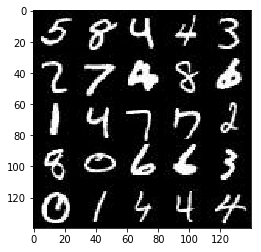

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

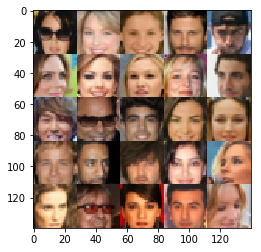

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [13]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # input 28 * 28 * 3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding= 'same')
        x1 = tf.maximum(.01 * x1, x1)
        
        ## 14 * 14 * 64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(x2 * .1, x2)
    
        ## 7 * 7 * 128
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * .1)
        
        ## 4 * 4 * 256
        flat = tf.reshape(x3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1, activation= None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_training=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    keep_prob = .9
    
    with tf.variable_scope('generator', reuse= not is_training):
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_training)
        x1 = tf.maximum(.1 * x1, x1)
        # 7 * 7 * 512
        
                
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_training)
        x2 = tf.maximum(.1 * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        ## 14 * 14 * 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_training)
        x3 = tf.maximum(.1 * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob= keep_prob)
        ## 28* 28 * 128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding = 'same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [31]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real) * .9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
                                 
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_logits_fake)))
                                 
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [32]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list = d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')): ##req. for batch normalization
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    steps = 0
    show_every = 100
    channels = 1
    
    if data_image_mode == 'RGB':
        channels = 3           
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)  
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                            
                batch_images = batch_images * 2
                            
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate })
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate })
                
                _ = sess.run(g_train_opt, feed_dict= {input_z: batch_z, lr: learning_rate })
                
                if steps % show_every == 0: 
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)
                    
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, { input_z: batch_z, input_real: batch_images, lr: learning_rate  })
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate })
                    saver.save(sess, './checkpoints/generator.ckpt')

                    
                    print("\n Epoch {}/{} Step {}".format(epoch_i + 1, epochs, steps),
                          "Discriminator Loss: {:.4f} ... ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
            train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images, lr: learning_rate })
            train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate })

            print("\n Epoch {}/{}...".format(epoch_i+1, epochs),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
                    #show_generator_output(sess, 10, input_z, out_channel_dim, image_mode)

                    
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.


 Epoch 1/2 Step 10 Discriminator Loss: 4.3416 ...  Generator Loss: 0.0235

 Epoch 1/2 Step 20 Discriminator Loss: 5.1780 ...  Generator Loss: 0.0142

 Epoch 1/2 Step 30 Discriminator Loss: 3.7649 ...  Generator Loss: 0.0476

 Epoch 1/2 Step 40 Discriminator Loss: 4.6635 ...  Generator Loss: 0.0189

 Epoch 1/2 Step 50 Discriminator Loss: 3.5705 ...  Generator Loss: 0.0828

 Epoch 1/2 Step 60 Discriminator Loss: 4.7101 ...  Generator Loss: 0.0255

 Epoch 1/2 Step 70 Discriminator Loss: 3.1765 ...  Generator Loss: 0.1044

 Epoch 1/2 Step 80 Discriminator Loss: 3.2055 ...  Generator Loss: 0.1315

 Epoch 1/2 Step 90 Discriminator Loss: 3.4496 ...  Generator Loss: 0.0925


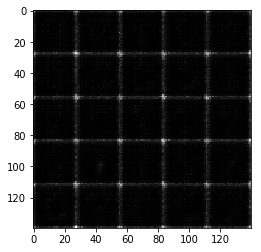


 Epoch 1/2 Step 100 Discriminator Loss: 3.6353 ...  Generator Loss: 0.0499

 Epoch 1/2 Step 110 Discriminator Loss: 4.4194 ...  Generator Loss: 0.0303

 Epoch 1/2 Step 120 Discriminator Loss: 3.6265 ...  Generator Loss: 0.1144

 Epoch 1/2 Step 130 Discriminator Loss: 2.5658 ...  Generator Loss: 0.2478

 Epoch 1/2 Step 140 Discriminator Loss: 2.3307 ...  Generator Loss: 0.2863

 Epoch 1/2 Step 150 Discriminator Loss: 2.3525 ...  Generator Loss: 0.2746

 Epoch 1/2 Step 160 Discriminator Loss: 2.5542 ...  Generator Loss: 0.1828

 Epoch 1/2 Step 170 Discriminator Loss: 3.2256 ...  Generator Loss: 0.1065

 Epoch 1/2 Step 180 Discriminator Loss: 2.9352 ...  Generator Loss: 0.1182

 Epoch 1/2 Step 190 Discriminator Loss: 2.6369 ...  Generator Loss: 0.1746


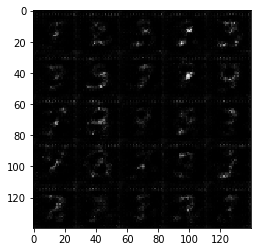


 Epoch 1/2 Step 200 Discriminator Loss: 2.7252 ...  Generator Loss: 0.2424

 Epoch 1/2 Step 210 Discriminator Loss: 2.8328 ...  Generator Loss: 0.1458

 Epoch 1/2 Step 220 Discriminator Loss: 2.6052 ...  Generator Loss: 0.1505

 Epoch 1/2 Step 230 Discriminator Loss: 2.2444 ...  Generator Loss: 0.2905

 Epoch 1/2 Step 240 Discriminator Loss: 2.6275 ...  Generator Loss: 0.2097

 Epoch 1/2 Step 250 Discriminator Loss: 2.2260 ...  Generator Loss: 0.3151

 Epoch 1/2 Step 260 Discriminator Loss: 2.0776 ...  Generator Loss: 0.3038

 Epoch 1/2 Step 270 Discriminator Loss: 2.0908 ...  Generator Loss: 0.3259

 Epoch 1/2 Step 280 Discriminator Loss: 2.1258 ...  Generator Loss: 0.3289

 Epoch 1/2 Step 290 Discriminator Loss: 1.9270 ...  Generator Loss: 0.3961


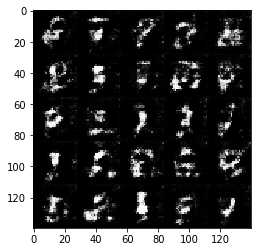


 Epoch 1/2 Step 300 Discriminator Loss: 2.0660 ...  Generator Loss: 0.3401

 Epoch 1/2 Step 310 Discriminator Loss: 2.1611 ...  Generator Loss: 0.3086

 Epoch 1/2 Step 320 Discriminator Loss: 2.2425 ...  Generator Loss: 0.2789

 Epoch 1/2 Step 330 Discriminator Loss: 2.2916 ...  Generator Loss: 0.3070

 Epoch 1/2 Step 340 Discriminator Loss: 2.0613 ...  Generator Loss: 0.3412

 Epoch 1/2 Step 350 Discriminator Loss: 1.7895 ...  Generator Loss: 0.4446

 Epoch 1/2 Step 360 Discriminator Loss: 1.9460 ...  Generator Loss: 0.3805

 Epoch 1/2 Step 370 Discriminator Loss: 1.8768 ...  Generator Loss: 0.4248

 Epoch 1/2 Step 380 Discriminator Loss: 2.1524 ...  Generator Loss: 0.3191

 Epoch 1/2 Step 390 Discriminator Loss: 2.0574 ...  Generator Loss: 0.3684


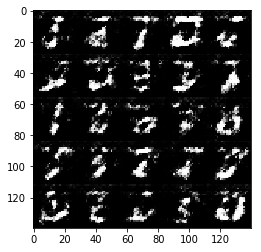


 Epoch 1/2 Step 400 Discriminator Loss: 1.8652 ...  Generator Loss: 0.3815

 Epoch 1/2 Step 410 Discriminator Loss: 2.1839 ...  Generator Loss: 0.3605

 Epoch 1/2 Step 420 Discriminator Loss: 2.2413 ...  Generator Loss: 0.2798

 Epoch 1/2 Step 430 Discriminator Loss: 2.2091 ...  Generator Loss: 0.2340

 Epoch 1/2 Step 440 Discriminator Loss: 2.2064 ...  Generator Loss: 0.2728

 Epoch 1/2 Step 450 Discriminator Loss: 2.3100 ...  Generator Loss: 0.2331

 Epoch 1/2 Step 460 Discriminator Loss: 2.0820 ...  Generator Loss: 0.3575

 Epoch 1/2 Step 470 Discriminator Loss: 2.1217 ...  Generator Loss: 0.3394

 Epoch 1/2 Step 480 Discriminator Loss: 2.0857 ...  Generator Loss: 0.3480

 Epoch 1/2 Step 490 Discriminator Loss: 2.0082 ...  Generator Loss: 0.2903


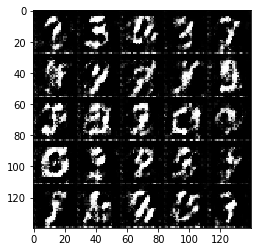


 Epoch 1/2 Step 500 Discriminator Loss: 2.0512 ...  Generator Loss: 0.3444

 Epoch 1/2 Step 510 Discriminator Loss: 2.1777 ...  Generator Loss: 0.2837

 Epoch 1/2 Step 520 Discriminator Loss: 2.1262 ...  Generator Loss: 0.3073

 Epoch 1/2 Step 530 Discriminator Loss: 2.2780 ...  Generator Loss: 0.2141

 Epoch 1/2 Step 540 Discriminator Loss: 1.9616 ...  Generator Loss: 0.3377

 Epoch 1/2 Step 550 Discriminator Loss: 2.0264 ...  Generator Loss: 0.3278

 Epoch 1/2 Step 560 Discriminator Loss: 2.2945 ...  Generator Loss: 0.2625

 Epoch 1/2 Step 570 Discriminator Loss: 1.8927 ...  Generator Loss: 0.3707

 Epoch 1/2 Step 580 Discriminator Loss: 1.7862 ...  Generator Loss: 0.4555

 Epoch 1/2 Step 590 Discriminator Loss: 1.9083 ...  Generator Loss: 0.4139


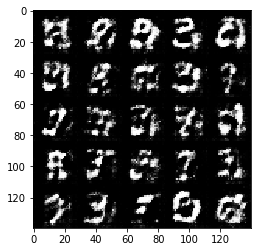


 Epoch 1/2 Step 600 Discriminator Loss: 2.2860 ...  Generator Loss: 0.3016

 Epoch 1/2 Step 610 Discriminator Loss: 2.2700 ...  Generator Loss: 0.2448

 Epoch 1/2 Step 620 Discriminator Loss: 1.8943 ...  Generator Loss: 0.3972

 Epoch 1/2 Step 630 Discriminator Loss: 1.7617 ...  Generator Loss: 0.4775

 Epoch 1/2 Step 640 Discriminator Loss: 1.9585 ...  Generator Loss: 0.4206

 Epoch 1/2 Step 650 Discriminator Loss: 2.2188 ...  Generator Loss: 0.2898

 Epoch 1/2 Step 660 Discriminator Loss: 2.2274 ...  Generator Loss: 0.3004

 Epoch 1/2 Step 670 Discriminator Loss: 2.2385 ...  Generator Loss: 0.2759

 Epoch 1/2 Step 680 Discriminator Loss: 2.0092 ...  Generator Loss: 0.2741

 Epoch 1/2 Step 690 Discriminator Loss: 2.0629 ...  Generator Loss: 0.2907


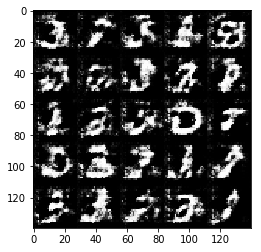


 Epoch 1/2 Step 700 Discriminator Loss: 2.4651 ...  Generator Loss: 0.1964

 Epoch 1/2 Step 710 Discriminator Loss: 2.1439 ...  Generator Loss: 0.3602

 Epoch 1/2 Step 720 Discriminator Loss: 2.0902 ...  Generator Loss: 0.3253

 Epoch 1/2 Step 730 Discriminator Loss: 2.1802 ...  Generator Loss: 0.2916

 Epoch 1/2 Step 740 Discriminator Loss: 2.6828 ...  Generator Loss: 0.1759

 Epoch 1/2 Step 750 Discriminator Loss: 2.3010 ...  Generator Loss: 0.2480

 Epoch 1/2 Step 760 Discriminator Loss: 2.2444 ...  Generator Loss: 0.3005

 Epoch 1/2 Step 770 Discriminator Loss: 1.9832 ...  Generator Loss: 0.3544

 Epoch 1/2 Step 780 Discriminator Loss: 2.0505 ...  Generator Loss: 0.3361

 Epoch 1/2 Step 790 Discriminator Loss: 2.8940 ...  Generator Loss: 0.1708


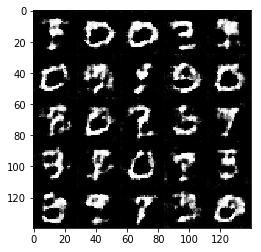


 Epoch 1/2 Step 800 Discriminator Loss: 2.1981 ...  Generator Loss: 0.3306

 Epoch 1/2 Step 810 Discriminator Loss: 1.8329 ...  Generator Loss: 0.3724

 Epoch 1/2 Step 820 Discriminator Loss: 2.0615 ...  Generator Loss: 0.3052

 Epoch 1/2 Step 830 Discriminator Loss: 2.4933 ...  Generator Loss: 0.2233

 Epoch 1/2 Step 840 Discriminator Loss: 3.1943 ...  Generator Loss: 0.1071

 Epoch 1/2 Step 850 Discriminator Loss: 1.6836 ...  Generator Loss: 0.5483

 Epoch 1/2 Step 860 Discriminator Loss: 1.8069 ...  Generator Loss: 0.4820

 Epoch 1/2 Step 870 Discriminator Loss: 2.2456 ...  Generator Loss: 0.2788

 Epoch 1/2 Step 880 Discriminator Loss: 2.0708 ...  Generator Loss: 0.3331

 Epoch 1/2 Step 890 Discriminator Loss: 1.7383 ...  Generator Loss: 0.4825


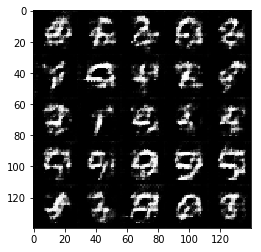


 Epoch 1/2 Step 900 Discriminator Loss: 1.7957 ...  Generator Loss: 0.4803

 Epoch 1/2 Step 910 Discriminator Loss: 1.8255 ...  Generator Loss: 0.4989

 Epoch 1/2 Step 920 Discriminator Loss: 2.0590 ...  Generator Loss: 0.3956

 Epoch 1/2 Step 930 Discriminator Loss: 2.0212 ...  Generator Loss: 0.3464

 Epoch 1/2 Step 940 Discriminator Loss: 2.0328 ...  Generator Loss: 0.3116

 Epoch 1/2 Step 950 Discriminator Loss: 2.0639 ...  Generator Loss: 0.2924

 Epoch 1/2 Step 960 Discriminator Loss: 1.9551 ...  Generator Loss: 0.3652

 Epoch 1/2 Step 970 Discriminator Loss: 1.9194 ...  Generator Loss: 0.3844

 Epoch 1/2 Step 980 Discriminator Loss: 1.7209 ...  Generator Loss: 0.5374

 Epoch 1/2 Step 990 Discriminator Loss: 1.8515 ...  Generator Loss: 0.4022


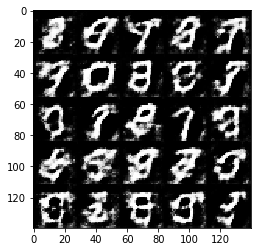


 Epoch 1/2 Step 1000 Discriminator Loss: 1.9007 ...  Generator Loss: 0.4065

 Epoch 1/2 Step 1010 Discriminator Loss: 2.1337 ...  Generator Loss: 0.3021

 Epoch 1/2 Step 1020 Discriminator Loss: 1.7687 ...  Generator Loss: 0.4868

 Epoch 1/2 Step 1030 Discriminator Loss: 1.7357 ...  Generator Loss: 0.4222

 Epoch 1/2 Step 1040 Discriminator Loss: 1.9192 ...  Generator Loss: 0.3973

 Epoch 1/2 Step 1050 Discriminator Loss: 1.9150 ...  Generator Loss: 0.3881

 Epoch 1/2 Step 1060 Discriminator Loss: 2.1110 ...  Generator Loss: 0.3373

 Epoch 1/2 Step 1070 Discriminator Loss: 1.8132 ...  Generator Loss: 0.3929

 Epoch 1/2 Step 1080 Discriminator Loss: 1.8445 ...  Generator Loss: 0.4051

 Epoch 1/2 Step 1090 Discriminator Loss: 1.7626 ...  Generator Loss: 0.5504


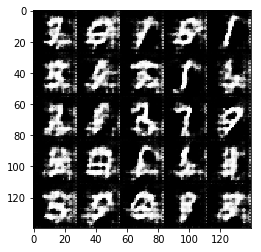


 Epoch 1/2 Step 1100 Discriminator Loss: 1.9316 ...  Generator Loss: 0.5003

 Epoch 1/2 Step 1110 Discriminator Loss: 2.0854 ...  Generator Loss: 0.3572

 Epoch 1/2 Step 1120 Discriminator Loss: 2.1008 ...  Generator Loss: 0.3359

 Epoch 1/2 Step 1130 Discriminator Loss: 1.6699 ...  Generator Loss: 0.4507

 Epoch 1/2 Step 1140 Discriminator Loss: 1.9299 ...  Generator Loss: 0.4047

 Epoch 1/2 Step 1150 Discriminator Loss: 1.8666 ...  Generator Loss: 0.4290

 Epoch 1/2 Step 1160 Discriminator Loss: 1.8582 ...  Generator Loss: 0.4067

 Epoch 1/2 Step 1170 Discriminator Loss: 2.1834 ...  Generator Loss: 0.3044

 Epoch 1/2 Step 1180 Discriminator Loss: 2.2087 ...  Generator Loss: 0.2495

 Epoch 1/2 Step 1190 Discriminator Loss: 1.9839 ...  Generator Loss: 0.3915


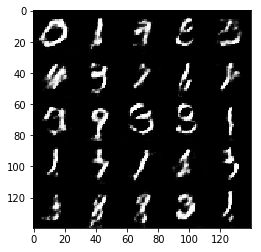


 Epoch 1/2 Step 1200 Discriminator Loss: 1.9348 ...  Generator Loss: 0.3429

 Epoch 1/2 Step 1210 Discriminator Loss: 1.9563 ...  Generator Loss: 0.4424

 Epoch 1/2 Step 1220 Discriminator Loss: 1.9098 ...  Generator Loss: 0.4121

 Epoch 1/2 Step 1230 Discriminator Loss: 1.7996 ...  Generator Loss: 0.4679

 Epoch 1/2 Step 1240 Discriminator Loss: 2.0660 ...  Generator Loss: 0.3303

 Epoch 1/2 Step 1250 Discriminator Loss: 2.0504 ...  Generator Loss: 0.2686

 Epoch 1/2 Step 1260 Discriminator Loss: 2.0861 ...  Generator Loss: 0.2959

 Epoch 1/2 Step 1270 Discriminator Loss: 1.9644 ...  Generator Loss: 0.3643

 Epoch 1/2 Step 1280 Discriminator Loss: 1.8148 ...  Generator Loss: 0.4269

 Epoch 1/2 Step 1290 Discriminator Loss: 1.8448 ...  Generator Loss: 0.4033


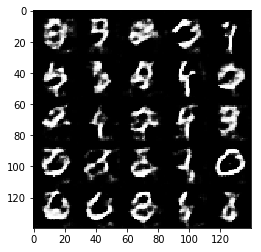


 Epoch 1/2 Step 1300 Discriminator Loss: 1.8358 ...  Generator Loss: 0.3613

 Epoch 1/2 Step 1310 Discriminator Loss: 2.2315 ...  Generator Loss: 0.2760

 Epoch 1/2 Step 1320 Discriminator Loss: 1.8727 ...  Generator Loss: 0.3698

 Epoch 1/2 Step 1330 Discriminator Loss: 2.2670 ...  Generator Loss: 0.2916

 Epoch 1/2 Step 1340 Discriminator Loss: 2.3604 ...  Generator Loss: 0.2482

 Epoch 1/2 Step 1350 Discriminator Loss: 1.8245 ...  Generator Loss: 0.4251

 Epoch 1/2 Step 1360 Discriminator Loss: 2.0238 ...  Generator Loss: 0.3257

 Epoch 1/2 Step 1370 Discriminator Loss: 2.1903 ...  Generator Loss: 0.2480

 Epoch 1/2 Step 1380 Discriminator Loss: 2.3966 ...  Generator Loss: 0.2426

 Epoch 1/2 Step 1390 Discriminator Loss: 1.9036 ...  Generator Loss: 0.4201


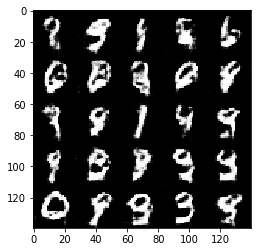


 Epoch 1/2 Step 1400 Discriminator Loss: 1.8258 ...  Generator Loss: 0.4548

 Epoch 1/2 Step 1410 Discriminator Loss: 1.8145 ...  Generator Loss: 0.4230

 Epoch 1/2 Step 1420 Discriminator Loss: 2.2762 ...  Generator Loss: 0.2557

 Epoch 1/2 Step 1430 Discriminator Loss: 2.3342 ...  Generator Loss: 0.2175

 Epoch 1/2 Step 1440 Discriminator Loss: 1.9544 ...  Generator Loss: 0.3690

 Epoch 1/2 Step 1450 Discriminator Loss: 1.8413 ...  Generator Loss: 0.3876

 Epoch 1/2 Step 1460 Discriminator Loss: 1.9198 ...  Generator Loss: 0.3995

 Epoch 1/2 Step 1470 Discriminator Loss: 2.1315 ...  Generator Loss: 0.2545

 Epoch 1/2 Step 1480 Discriminator Loss: 2.3788 ...  Generator Loss: 0.2561

 Epoch 1/2 Step 1490 Discriminator Loss: 2.0795 ...  Generator Loss: 0.3322


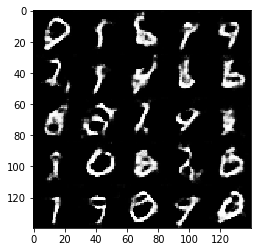


 Epoch 1/2 Step 1500 Discriminator Loss: 2.0588 ...  Generator Loss: 0.3770

 Epoch 1/2 Step 1510 Discriminator Loss: 2.1219 ...  Generator Loss: 0.3322

 Epoch 1/2 Step 1520 Discriminator Loss: 1.7395 ...  Generator Loss: 0.4197

 Epoch 1/2 Step 1530 Discriminator Loss: 1.9328 ...  Generator Loss: 0.3023

 Epoch 1/2 Step 1540 Discriminator Loss: 1.9544 ...  Generator Loss: 0.3306

 Epoch 1/2 Step 1550 Discriminator Loss: 2.0443 ...  Generator Loss: 0.3195

 Epoch 1/2 Step 1560 Discriminator Loss: 1.8926 ...  Generator Loss: 0.3785

 Epoch 1/2 Step 1570 Discriminator Loss: 2.0559 ...  Generator Loss: 0.3602

 Epoch 1/2 Step 1580 Discriminator Loss: 1.9715 ...  Generator Loss: 0.3482

 Epoch 1/2 Step 1590 Discriminator Loss: 1.9116 ...  Generator Loss: 0.3627


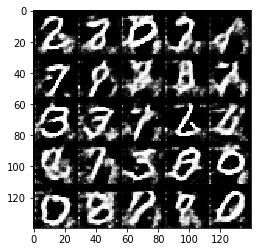


 Epoch 1/2 Step 1600 Discriminator Loss: 1.9638 ...  Generator Loss: 0.3919

 Epoch 1/2 Step 1610 Discriminator Loss: 1.9842 ...  Generator Loss: 0.4763


KeyboardInterrupt: 

In [36]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.


 Epoch 1/1 Step 10 Discriminator Loss: 7.4950 ...  Generator Loss: 0.0019

 Epoch 1/1 Step 20 Discriminator Loss: 6.3705 ...  Generator Loss: 0.0048

 Epoch 1/1 Step 30 Discriminator Loss: 4.4725 ...  Generator Loss: 0.0281

 Epoch 1/1 Step 40 Discriminator Loss: 5.3645 ...  Generator Loss: 0.0110

 Epoch 1/1 Step 50 Discriminator Loss: 4.4943 ...  Generator Loss: 0.0230

 Epoch 1/1 Step 60 Discriminator Loss: 6.6806 ...  Generator Loss: 0.0028

 Epoch 1/1 Step 70 Discriminator Loss: 6.4063 ...  Generator Loss: 0.0130

 Epoch 1/1 Step 80 Discriminator Loss: 5.8819 ...  Generator Loss: 0.0205

 Epoch 1/1 Step 90 Discriminator Loss: 4.0654 ...  Generator Loss: 0.0290


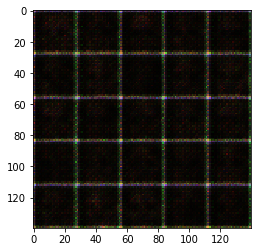


 Epoch 1/1 Step 100 Discriminator Loss: 3.9937 ...  Generator Loss: 0.0424

 Epoch 1/1 Step 110 Discriminator Loss: 5.7671 ...  Generator Loss: 0.0087

 Epoch 1/1 Step 120 Discriminator Loss: 4.9516 ...  Generator Loss: 0.0206

 Epoch 1/1 Step 130 Discriminator Loss: 4.1761 ...  Generator Loss: 0.0449

 Epoch 1/1 Step 140 Discriminator Loss: 5.3217 ...  Generator Loss: 0.0100

 Epoch 1/1 Step 150 Discriminator Loss: 5.2708 ...  Generator Loss: 0.0397

 Epoch 1/1 Step 160 Discriminator Loss: 3.0587 ...  Generator Loss: 0.0815

 Epoch 1/1 Step 170 Discriminator Loss: 3.1609 ...  Generator Loss: 0.0607

 Epoch 1/1 Step 180 Discriminator Loss: 0.8306 ...  Generator Loss: 1.3387

 Epoch 1/1 Step 190 Discriminator Loss: 3.5507 ...  Generator Loss: 0.0786


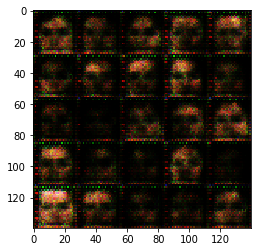


 Epoch 1/1 Step 200 Discriminator Loss: 3.0176 ...  Generator Loss: 0.1371

 Epoch 1/1 Step 210 Discriminator Loss: 3.6594 ...  Generator Loss: 0.0527

 Epoch 1/1 Step 220 Discriminator Loss: 3.2089 ...  Generator Loss: 0.0798

 Epoch 1/1 Step 230 Discriminator Loss: 2.5783 ...  Generator Loss: 0.1336

 Epoch 1/1 Step 240 Discriminator Loss: 3.5953 ...  Generator Loss: 0.0529

 Epoch 1/1 Step 250 Discriminator Loss: 3.2187 ...  Generator Loss: 0.0843

 Epoch 1/1 Step 260 Discriminator Loss: 2.8972 ...  Generator Loss: 0.0731

 Epoch 1/1 Step 270 Discriminator Loss: 3.5517 ...  Generator Loss: 0.0925

 Epoch 1/1 Step 280 Discriminator Loss: 3.7907 ...  Generator Loss: 0.0420

 Epoch 1/1 Step 290 Discriminator Loss: 2.9510 ...  Generator Loss: 0.1230


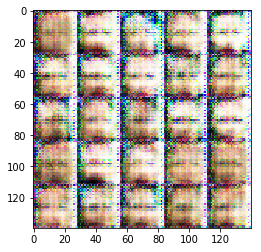


 Epoch 1/1 Step 300 Discriminator Loss: 3.1461 ...  Generator Loss: 0.0606

 Epoch 1/1 Step 310 Discriminator Loss: 4.4678 ...  Generator Loss: 0.2011

 Epoch 1/1 Step 320 Discriminator Loss: 3.2929 ...  Generator Loss: 0.1129

 Epoch 1/1 Step 330 Discriminator Loss: 2.9965 ...  Generator Loss: 0.1561

 Epoch 1/1 Step 340 Discriminator Loss: 2.2053 ...  Generator Loss: 0.2229

 Epoch 1/1 Step 350 Discriminator Loss: 3.2200 ...  Generator Loss: 0.1119

 Epoch 1/1 Step 360 Discriminator Loss: 4.1918 ...  Generator Loss: 0.0996

 Epoch 1/1 Step 370 Discriminator Loss: 2.7391 ...  Generator Loss: 0.1526

 Epoch 1/1 Step 380 Discriminator Loss: 2.8346 ...  Generator Loss: 0.1694

 Epoch 1/1 Step 390 Discriminator Loss: 2.6698 ...  Generator Loss: 0.2260


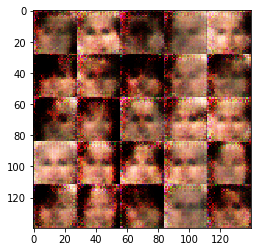


 Epoch 1/1 Step 400 Discriminator Loss: 3.0494 ...  Generator Loss: 0.1539

 Epoch 1/1 Step 410 Discriminator Loss: 3.1150 ...  Generator Loss: 0.1137

 Epoch 1/1 Step 420 Discriminator Loss: 2.4708 ...  Generator Loss: 0.2097

 Epoch 1/1 Step 430 Discriminator Loss: 2.6220 ...  Generator Loss: 0.1959

 Epoch 1/1 Step 440 Discriminator Loss: 2.6412 ...  Generator Loss: 0.2001

 Epoch 1/1 Step 450 Discriminator Loss: 2.4852 ...  Generator Loss: 0.2364

 Epoch 1/1 Step 460 Discriminator Loss: 2.4318 ...  Generator Loss: 0.1958

 Epoch 1/1 Step 470 Discriminator Loss: 3.1749 ...  Generator Loss: 0.1086

 Epoch 1/1 Step 480 Discriminator Loss: 3.0528 ...  Generator Loss: 0.1820

 Epoch 1/1 Step 490 Discriminator Loss: 2.6645 ...  Generator Loss: 0.2659


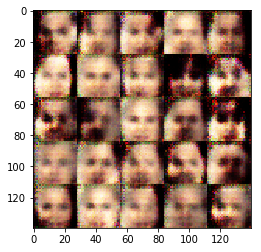


 Epoch 1/1 Step 500 Discriminator Loss: 2.3069 ...  Generator Loss: 0.3131

 Epoch 1/1 Step 510 Discriminator Loss: 3.1774 ...  Generator Loss: 0.0995

 Epoch 1/1 Step 520 Discriminator Loss: 2.7239 ...  Generator Loss: 0.1561

 Epoch 1/1 Step 530 Discriminator Loss: 2.9190 ...  Generator Loss: 0.2573

 Epoch 1/1 Step 540 Discriminator Loss: 2.3050 ...  Generator Loss: 0.3978

 Epoch 1/1 Step 550 Discriminator Loss: 2.3835 ...  Generator Loss: 0.2688

 Epoch 1/1 Step 560 Discriminator Loss: 2.6417 ...  Generator Loss: 0.2703

 Epoch 1/1 Step 570 Discriminator Loss: 2.2578 ...  Generator Loss: 0.3038

 Epoch 1/1 Step 580 Discriminator Loss: 2.6855 ...  Generator Loss: 0.2432

 Epoch 1/1 Step 590 Discriminator Loss: 2.1661 ...  Generator Loss: 0.3464


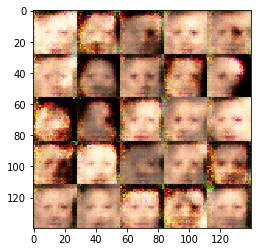


 Epoch 1/1 Step 600 Discriminator Loss: 2.0833 ...  Generator Loss: 0.3111

 Epoch 1/1 Step 610 Discriminator Loss: 2.0780 ...  Generator Loss: 0.3251

 Epoch 1/1 Step 620 Discriminator Loss: 2.0171 ...  Generator Loss: 0.3303

 Epoch 1/1 Step 630 Discriminator Loss: 2.0536 ...  Generator Loss: 0.3446

 Epoch 1/1 Step 640 Discriminator Loss: 2.2435 ...  Generator Loss: 0.2412

 Epoch 1/1 Step 650 Discriminator Loss: 2.7611 ...  Generator Loss: 0.2048

 Epoch 1/1 Step 660 Discriminator Loss: 1.9917 ...  Generator Loss: 0.3409

 Epoch 1/1 Step 670 Discriminator Loss: 3.1783 ...  Generator Loss: 0.1167

 Epoch 1/1 Step 680 Discriminator Loss: 2.8279 ...  Generator Loss: 0.1870

 Epoch 1/1 Step 690 Discriminator Loss: 2.5538 ...  Generator Loss: 0.1828


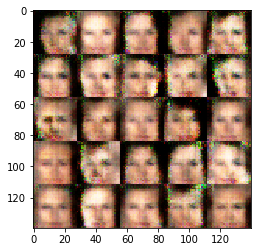


 Epoch 1/1 Step 700 Discriminator Loss: 2.0710 ...  Generator Loss: 0.3792

 Epoch 1/1 Step 710 Discriminator Loss: 2.4221 ...  Generator Loss: 0.2563

 Epoch 1/1 Step 720 Discriminator Loss: 2.1755 ...  Generator Loss: 0.3309

 Epoch 1/1 Step 730 Discriminator Loss: 2.5245 ...  Generator Loss: 0.1968

 Epoch 1/1 Step 740 Discriminator Loss: 2.8885 ...  Generator Loss: 0.1890

 Epoch 1/1 Step 750 Discriminator Loss: 2.6657 ...  Generator Loss: 0.1842

 Epoch 1/1 Step 760 Discriminator Loss: 2.4819 ...  Generator Loss: 0.2334

 Epoch 1/1 Step 770 Discriminator Loss: 2.3892 ...  Generator Loss: 0.2528

 Epoch 1/1 Step 780 Discriminator Loss: 2.9788 ...  Generator Loss: 0.0924

 Epoch 1/1 Step 790 Discriminator Loss: 2.4647 ...  Generator Loss: 0.2708


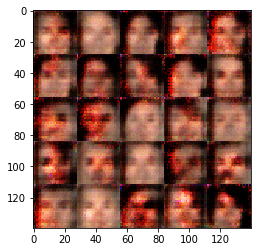


 Epoch 1/1 Step 800 Discriminator Loss: 2.2581 ...  Generator Loss: 0.2275

 Epoch 1/1 Step 810 Discriminator Loss: 2.3995 ...  Generator Loss: 0.2945

 Epoch 1/1 Step 820 Discriminator Loss: 2.2067 ...  Generator Loss: 0.2566

 Epoch 1/1 Step 830 Discriminator Loss: 2.6254 ...  Generator Loss: 0.1819

 Epoch 1/1 Step 840 Discriminator Loss: 2.3712 ...  Generator Loss: 0.3439

 Epoch 1/1 Step 850 Discriminator Loss: 2.4205 ...  Generator Loss: 0.2111

 Epoch 1/1 Step 860 Discriminator Loss: 2.4902 ...  Generator Loss: 0.1884

 Epoch 1/1 Step 870 Discriminator Loss: 2.9439 ...  Generator Loss: 0.1587

 Epoch 1/1 Step 880 Discriminator Loss: 2.2434 ...  Generator Loss: 0.2458

 Epoch 1/1 Step 890 Discriminator Loss: 2.7405 ...  Generator Loss: 0.1992


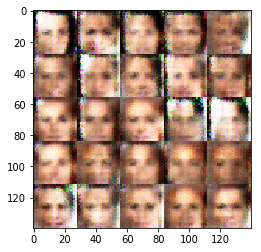


 Epoch 1/1 Step 900 Discriminator Loss: 2.3983 ...  Generator Loss: 0.2577

 Epoch 1/1 Step 910 Discriminator Loss: 2.4291 ...  Generator Loss: 0.2585

 Epoch 1/1 Step 920 Discriminator Loss: 2.3386 ...  Generator Loss: 0.3535

 Epoch 1/1 Step 930 Discriminator Loss: 3.1905 ...  Generator Loss: 0.1473

 Epoch 1/1 Step 940 Discriminator Loss: 2.1636 ...  Generator Loss: 0.2782

 Epoch 1/1 Step 950 Discriminator Loss: 3.1272 ...  Generator Loss: 0.1097

 Epoch 1/1 Step 960 Discriminator Loss: 1.7700 ...  Generator Loss: 0.4117

 Epoch 1/1 Step 970 Discriminator Loss: 2.4273 ...  Generator Loss: 0.2904

 Epoch 1/1 Step 980 Discriminator Loss: 2.2023 ...  Generator Loss: 0.2367

 Epoch 1/1 Step 990 Discriminator Loss: 2.3646 ...  Generator Loss: 0.2564


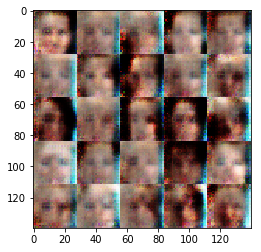


 Epoch 1/1 Step 1000 Discriminator Loss: 2.6321 ...  Generator Loss: 0.1915

 Epoch 1/1 Step 1010 Discriminator Loss: 2.5710 ...  Generator Loss: 0.1883

 Epoch 1/1 Step 1020 Discriminator Loss: 2.6504 ...  Generator Loss: 0.1505

 Epoch 1/1 Step 1030 Discriminator Loss: 3.2512 ...  Generator Loss: 0.1417

 Epoch 1/1 Step 1040 Discriminator Loss: 2.4891 ...  Generator Loss: 0.2771

 Epoch 1/1 Step 1050 Discriminator Loss: 1.9201 ...  Generator Loss: 0.4368

 Epoch 1/1 Step 1060 Discriminator Loss: 2.4013 ...  Generator Loss: 0.2675

 Epoch 1/1 Step 1070 Discriminator Loss: 1.9700 ...  Generator Loss: 0.4002

 Epoch 1/1 Step 1080 Discriminator Loss: 2.3632 ...  Generator Loss: 0.2390

 Epoch 1/1 Step 1090 Discriminator Loss: 1.9579 ...  Generator Loss: 0.4391


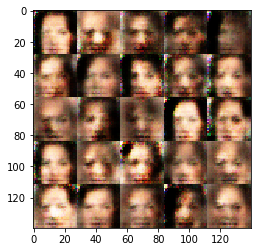


 Epoch 1/1 Step 1100 Discriminator Loss: 2.3884 ...  Generator Loss: 0.2716

 Epoch 1/1 Step 1110 Discriminator Loss: 2.0183 ...  Generator Loss: 0.3398

 Epoch 1/1 Step 1120 Discriminator Loss: 2.1992 ...  Generator Loss: 0.3111

 Epoch 1/1 Step 1130 Discriminator Loss: 2.1785 ...  Generator Loss: 0.2443

 Epoch 1/1 Step 1140 Discriminator Loss: 2.5119 ...  Generator Loss: 0.2386

 Epoch 1/1 Step 1150 Discriminator Loss: 2.4108 ...  Generator Loss: 0.2006

 Epoch 1/1 Step 1160 Discriminator Loss: 2.3071 ...  Generator Loss: 0.2628

 Epoch 1/1 Step 1170 Discriminator Loss: 2.5695 ...  Generator Loss: 0.2431

 Epoch 1/1 Step 1180 Discriminator Loss: 2.4606 ...  Generator Loss: 0.1856

 Epoch 1/1 Step 1190 Discriminator Loss: 3.0365 ...  Generator Loss: 0.1239


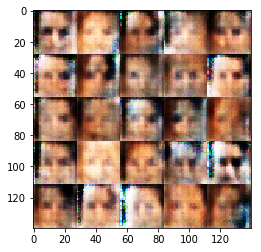


 Epoch 1/1 Step 1200 Discriminator Loss: 2.5623 ...  Generator Loss: 0.1707

 Epoch 1/1 Step 1210 Discriminator Loss: 2.5556 ...  Generator Loss: 0.2438

 Epoch 1/1 Step 1220 Discriminator Loss: 2.3520 ...  Generator Loss: 0.2870

 Epoch 1/1 Step 1230 Discriminator Loss: 2.6618 ...  Generator Loss: 0.2240

 Epoch 1/1 Step 1240 Discriminator Loss: 3.0430 ...  Generator Loss: 0.1900

 Epoch 1/1 Step 1250 Discriminator Loss: 2.4202 ...  Generator Loss: 0.2465

 Epoch 1/1 Step 1260 Discriminator Loss: 2.1315 ...  Generator Loss: 0.2766

 Epoch 1/1 Step 1270 Discriminator Loss: 2.3279 ...  Generator Loss: 0.2446

 Epoch 1/1 Step 1280 Discriminator Loss: 2.3488 ...  Generator Loss: 0.2452

 Epoch 1/1 Step 1290 Discriminator Loss: 2.6581 ...  Generator Loss: 0.2304


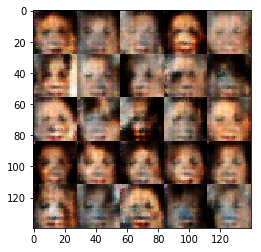


 Epoch 1/1 Step 1300 Discriminator Loss: 2.7007 ...  Generator Loss: 0.2717

 Epoch 1/1 Step 1310 Discriminator Loss: 2.2136 ...  Generator Loss: 0.3192

 Epoch 1/1 Step 1320 Discriminator Loss: 2.5701 ...  Generator Loss: 0.2252

 Epoch 1/1 Step 1330 Discriminator Loss: 2.3867 ...  Generator Loss: 0.2241

 Epoch 1/1 Step 1340 Discriminator Loss: 2.0723 ...  Generator Loss: 0.3111

 Epoch 1/1 Step 1350 Discriminator Loss: 2.5847 ...  Generator Loss: 0.2461

 Epoch 1/1 Step 1360 Discriminator Loss: 2.3040 ...  Generator Loss: 0.3212

 Epoch 1/1 Step 1370 Discriminator Loss: 2.5170 ...  Generator Loss: 0.3177

 Epoch 1/1 Step 1380 Discriminator Loss: 1.8481 ...  Generator Loss: 0.3882

 Epoch 1/1 Step 1390 Discriminator Loss: 1.9568 ...  Generator Loss: 0.3197


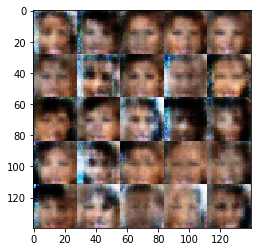


 Epoch 1/1 Step 1400 Discriminator Loss: 2.4840 ...  Generator Loss: 0.1964

 Epoch 1/1 Step 1410 Discriminator Loss: 2.9904 ...  Generator Loss: 0.1286

 Epoch 1/1 Step 1420 Discriminator Loss: 2.4966 ...  Generator Loss: 0.2304

 Epoch 1/1 Step 1430 Discriminator Loss: 2.6481 ...  Generator Loss: 0.2126

 Epoch 1/1 Step 1440 Discriminator Loss: 2.3123 ...  Generator Loss: 0.2595

 Epoch 1/1 Step 1450 Discriminator Loss: 2.4351 ...  Generator Loss: 0.2296

 Epoch 1/1 Step 1460 Discriminator Loss: 2.5748 ...  Generator Loss: 0.1887

 Epoch 1/1 Step 1470 Discriminator Loss: 2.0897 ...  Generator Loss: 0.2973

 Epoch 1/1 Step 1480 Discriminator Loss: 2.7421 ...  Generator Loss: 0.1946

 Epoch 1/1 Step 1490 Discriminator Loss: 2.7332 ...  Generator Loss: 0.1864


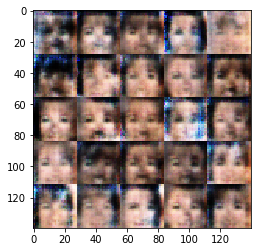


 Epoch 1/1 Step 1500 Discriminator Loss: 2.1950 ...  Generator Loss: 0.2428

 Epoch 1/1 Step 1510 Discriminator Loss: 2.1701 ...  Generator Loss: 0.3025

 Epoch 1/1 Step 1520 Discriminator Loss: 2.4598 ...  Generator Loss: 0.2189

 Epoch 1/1 Step 1530 Discriminator Loss: 2.1886 ...  Generator Loss: 0.3095

 Epoch 1/1 Step 1540 Discriminator Loss: 2.3899 ...  Generator Loss: 0.2885

 Epoch 1/1 Step 1550 Discriminator Loss: 2.9509 ...  Generator Loss: 0.1828

 Epoch 1/1 Step 1560 Discriminator Loss: 2.6109 ...  Generator Loss: 0.1784

 Epoch 1/1 Step 1570 Discriminator Loss: 2.5119 ...  Generator Loss: 0.2567

 Epoch 1/1 Step 1580 Discriminator Loss: 2.3867 ...  Generator Loss: 0.2732

 Epoch 1/1 Step 1590 Discriminator Loss: 2.2249 ...  Generator Loss: 0.2436


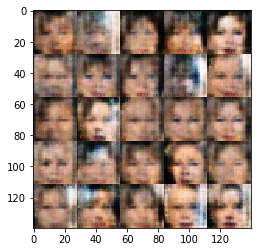


 Epoch 1/1 Step 1600 Discriminator Loss: 2.1978 ...  Generator Loss: 0.2343

 Epoch 1/1 Step 1610 Discriminator Loss: 2.4418 ...  Generator Loss: 0.2450

 Epoch 1/1 Step 1620 Discriminator Loss: 2.5439 ...  Generator Loss: 0.1923

 Epoch 1/1 Step 1630 Discriminator Loss: 2.7237 ...  Generator Loss: 0.1879

 Epoch 1/1 Step 1640 Discriminator Loss: 2.2310 ...  Generator Loss: 0.2881

 Epoch 1/1 Step 1650 Discriminator Loss: 1.9966 ...  Generator Loss: 0.3539

 Epoch 1/1 Step 1660 Discriminator Loss: 2.3876 ...  Generator Loss: 0.2957

 Epoch 1/1 Step 1670 Discriminator Loss: 1.9875 ...  Generator Loss: 0.3348

 Epoch 1/1 Step 1680 Discriminator Loss: 2.2612 ...  Generator Loss: 0.2417

 Epoch 1/1 Step 1690 Discriminator Loss: 2.3673 ...  Generator Loss: 0.2422


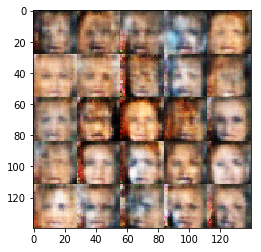


 Epoch 1/1 Step 1700 Discriminator Loss: 1.8602 ...  Generator Loss: 0.5030

 Epoch 1/1 Step 1710 Discriminator Loss: 1.8527 ...  Generator Loss: 0.3788

 Epoch 1/1 Step 1720 Discriminator Loss: 2.4425 ...  Generator Loss: 0.2817

 Epoch 1/1 Step 1730 Discriminator Loss: 2.0161 ...  Generator Loss: 0.3576

 Epoch 1/1 Step 1740 Discriminator Loss: 2.0666 ...  Generator Loss: 0.3836

 Epoch 1/1 Step 1750 Discriminator Loss: 2.0530 ...  Generator Loss: 0.3394

 Epoch 1/1 Step 1760 Discriminator Loss: 2.0031 ...  Generator Loss: 0.3395

 Epoch 1/1 Step 1770 Discriminator Loss: 2.3484 ...  Generator Loss: 0.3389

 Epoch 1/1 Step 1780 Discriminator Loss: 2.2209 ...  Generator Loss: 0.3425

 Epoch 1/1 Step 1790 Discriminator Loss: 2.1046 ...  Generator Loss: 0.3715


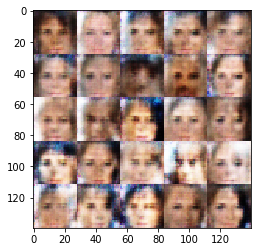


 Epoch 1/1 Step 1800 Discriminator Loss: 1.9402 ...  Generator Loss: 0.3452

 Epoch 1/1 Step 1810 Discriminator Loss: 2.0993 ...  Generator Loss: 0.4320

 Epoch 1/1 Step 1820 Discriminator Loss: 2.1187 ...  Generator Loss: 0.2679

 Epoch 1/1 Step 1830 Discriminator Loss: 2.4132 ...  Generator Loss: 0.2749

 Epoch 1/1 Step 1840 Discriminator Loss: 2.2059 ...  Generator Loss: 0.2571

 Epoch 1/1 Step 1850 Discriminator Loss: 2.0900 ...  Generator Loss: 0.3186

 Epoch 1/1 Step 1860 Discriminator Loss: 2.4655 ...  Generator Loss: 0.2441

 Epoch 1/1 Step 1870 Discriminator Loss: 2.2301 ...  Generator Loss: 0.2884

 Epoch 1/1 Step 1880 Discriminator Loss: 2.1294 ...  Generator Loss: 0.3385

 Epoch 1/1 Step 1890 Discriminator Loss: 2.1439 ...  Generator Loss: 0.3040


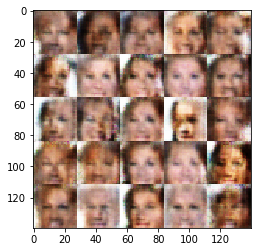


 Epoch 1/1 Step 1900 Discriminator Loss: 2.1713 ...  Generator Loss: 0.2941

 Epoch 1/1 Step 1910 Discriminator Loss: 2.2244 ...  Generator Loss: 0.3064

 Epoch 1/1 Step 1920 Discriminator Loss: 1.9437 ...  Generator Loss: 0.3778

 Epoch 1/1 Step 1930 Discriminator Loss: 1.9959 ...  Generator Loss: 0.3243

 Epoch 1/1 Step 1940 Discriminator Loss: 2.1525 ...  Generator Loss: 0.3054

 Epoch 1/1 Step 1950 Discriminator Loss: 1.8382 ...  Generator Loss: 0.3921

 Epoch 1/1 Step 1960 Discriminator Loss: 2.4233 ...  Generator Loss: 0.2623

 Epoch 1/1 Step 1970 Discriminator Loss: 2.1401 ...  Generator Loss: 0.2965

 Epoch 1/1 Step 1980 Discriminator Loss: 2.2005 ...  Generator Loss: 0.2370

 Epoch 1/1 Step 1990 Discriminator Loss: 2.1771 ...  Generator Loss: 0.3307


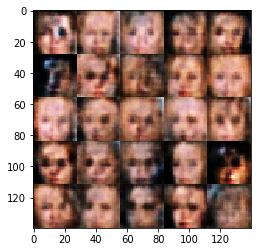


 Epoch 1/1 Step 2000 Discriminator Loss: 2.0756 ...  Generator Loss: 0.3636

 Epoch 1/1 Step 2010 Discriminator Loss: 1.8554 ...  Generator Loss: 0.4289

 Epoch 1/1 Step 2020 Discriminator Loss: 2.3134 ...  Generator Loss: 0.3044

 Epoch 1/1 Step 2030 Discriminator Loss: 2.4981 ...  Generator Loss: 0.1885

 Epoch 1/1 Step 2040 Discriminator Loss: 2.2554 ...  Generator Loss: 0.3202

 Epoch 1/1 Step 2050 Discriminator Loss: 2.1391 ...  Generator Loss: 0.2996

 Epoch 1/1 Step 2060 Discriminator Loss: 2.2790 ...  Generator Loss: 0.2973

 Epoch 1/1 Step 2070 Discriminator Loss: 2.4476 ...  Generator Loss: 0.2518

 Epoch 1/1 Step 2080 Discriminator Loss: 2.1699 ...  Generator Loss: 0.2775

 Epoch 1/1 Step 2090 Discriminator Loss: 1.9223 ...  Generator Loss: 0.4151


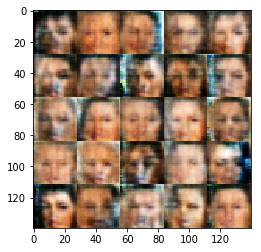


 Epoch 1/1 Step 2100 Discriminator Loss: 2.3323 ...  Generator Loss: 0.2898

 Epoch 1/1 Step 2110 Discriminator Loss: 2.4291 ...  Generator Loss: 0.2547

 Epoch 1/1 Step 2120 Discriminator Loss: 2.4457 ...  Generator Loss: 0.2655

 Epoch 1/1 Step 2130 Discriminator Loss: 2.1575 ...  Generator Loss: 0.3209

 Epoch 1/1 Step 2140 Discriminator Loss: 2.1325 ...  Generator Loss: 0.3252

 Epoch 1/1 Step 2150 Discriminator Loss: 1.9597 ...  Generator Loss: 0.3815

 Epoch 1/1 Step 2160 Discriminator Loss: 2.4567 ...  Generator Loss: 0.2123

 Epoch 1/1 Step 2170 Discriminator Loss: 2.1153 ...  Generator Loss: 0.3301

 Epoch 1/1 Step 2180 Discriminator Loss: 1.7215 ...  Generator Loss: 0.4299

 Epoch 1/1 Step 2190 Discriminator Loss: 1.7829 ...  Generator Loss: 0.4908


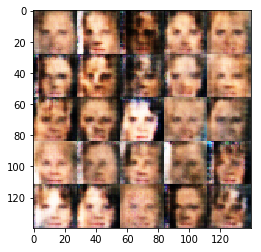


 Epoch 1/1 Step 2200 Discriminator Loss: 1.9367 ...  Generator Loss: 0.4176

 Epoch 1/1 Step 2210 Discriminator Loss: 1.9276 ...  Generator Loss: 0.4533

 Epoch 1/1 Step 2220 Discriminator Loss: 2.0728 ...  Generator Loss: 0.3213

 Epoch 1/1 Step 2230 Discriminator Loss: 2.2770 ...  Generator Loss: 0.3409

 Epoch 1/1 Step 2240 Discriminator Loss: 1.9735 ...  Generator Loss: 0.4005

 Epoch 1/1 Step 2250 Discriminator Loss: 2.0644 ...  Generator Loss: 0.3282

 Epoch 1/1 Step 2260 Discriminator Loss: 2.0175 ...  Generator Loss: 0.3625

 Epoch 1/1 Step 2270 Discriminator Loss: 2.0371 ...  Generator Loss: 0.3191

 Epoch 1/1 Step 2280 Discriminator Loss: 2.3630 ...  Generator Loss: 0.2476

 Epoch 1/1 Step 2290 Discriminator Loss: 2.4358 ...  Generator Loss: 0.2126


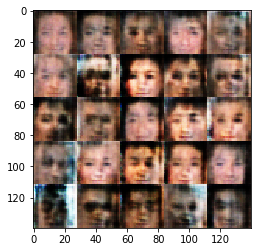


 Epoch 1/1 Step 2300 Discriminator Loss: 2.2806 ...  Generator Loss: 0.2550

 Epoch 1/1 Step 2310 Discriminator Loss: 2.0769 ...  Generator Loss: 0.3093

 Epoch 1/1 Step 2320 Discriminator Loss: 2.2085 ...  Generator Loss: 0.2589

 Epoch 1/1 Step 2330 Discriminator Loss: 2.4430 ...  Generator Loss: 0.2582

 Epoch 1/1 Step 2340 Discriminator Loss: 2.0832 ...  Generator Loss: 0.2906

 Epoch 1/1 Step 2350 Discriminator Loss: 1.9060 ...  Generator Loss: 0.3319

 Epoch 1/1 Step 2360 Discriminator Loss: 2.1096 ...  Generator Loss: 0.2663

 Epoch 1/1 Step 2370 Discriminator Loss: 2.0727 ...  Generator Loss: 0.3921

 Epoch 1/1 Step 2380 Discriminator Loss: 2.1534 ...  Generator Loss: 0.2597

 Epoch 1/1 Step 2390 Discriminator Loss: 2.2318 ...  Generator Loss: 0.2821


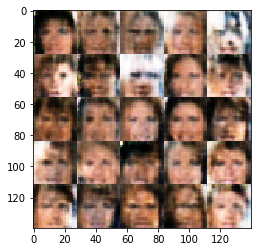


 Epoch 1/1 Step 2400 Discriminator Loss: 2.1836 ...  Generator Loss: 0.3154

 Epoch 1/1 Step 2410 Discriminator Loss: 2.0861 ...  Generator Loss: 0.3715

 Epoch 1/1 Step 2420 Discriminator Loss: 2.0775 ...  Generator Loss: 0.3335

 Epoch 1/1 Step 2430 Discriminator Loss: 2.0227 ...  Generator Loss: 0.3559

 Epoch 1/1 Step 2440 Discriminator Loss: 2.1592 ...  Generator Loss: 0.3023

 Epoch 1/1 Step 2450 Discriminator Loss: 2.2777 ...  Generator Loss: 0.2860

 Epoch 1/1 Step 2460 Discriminator Loss: 2.1593 ...  Generator Loss: 0.2814

 Epoch 1/1 Step 2470 Discriminator Loss: 2.2009 ...  Generator Loss: 0.2614

 Epoch 1/1 Step 2480 Discriminator Loss: 2.1081 ...  Generator Loss: 0.2990

 Epoch 1/1 Step 2490 Discriminator Loss: 2.3951 ...  Generator Loss: 0.2785


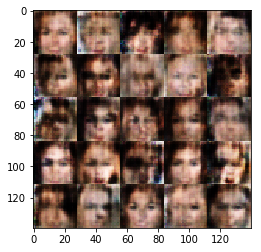


 Epoch 1/1 Step 2500 Discriminator Loss: 2.2704 ...  Generator Loss: 0.2520

 Epoch 1/1 Step 2510 Discriminator Loss: 2.1899 ...  Generator Loss: 0.2418

 Epoch 1/1 Step 2520 Discriminator Loss: 2.3252 ...  Generator Loss: 0.2524

 Epoch 1/1 Step 2530 Discriminator Loss: 2.8969 ...  Generator Loss: 0.1622

 Epoch 1/1 Step 2540 Discriminator Loss: 2.2357 ...  Generator Loss: 0.2853

 Epoch 1/1 Step 2550 Discriminator Loss: 2.2011 ...  Generator Loss: 0.2657

 Epoch 1/1 Step 2560 Discriminator Loss: 2.2718 ...  Generator Loss: 0.2462

 Epoch 1/1 Step 2570 Discriminator Loss: 2.1149 ...  Generator Loss: 0.3537

 Epoch 1/1 Step 2580 Discriminator Loss: 2.2070 ...  Generator Loss: 0.2787

 Epoch 1/1 Step 2590 Discriminator Loss: 1.8593 ...  Generator Loss: 0.4607


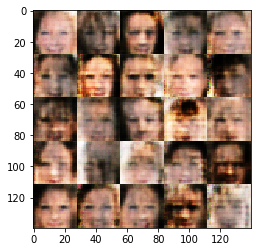


 Epoch 1/1 Step 2600 Discriminator Loss: 2.0002 ...  Generator Loss: 0.3498

 Epoch 1/1 Step 2610 Discriminator Loss: 1.9217 ...  Generator Loss: 0.3991

 Epoch 1/1 Step 2620 Discriminator Loss: 2.1021 ...  Generator Loss: 0.3418

 Epoch 1/1 Step 2630 Discriminator Loss: 2.0764 ...  Generator Loss: 0.3291

 Epoch 1/1 Step 2640 Discriminator Loss: 2.2347 ...  Generator Loss: 0.4098

 Epoch 1/1 Step 2650 Discriminator Loss: 2.0905 ...  Generator Loss: 0.2882

 Epoch 1/1 Step 2660 Discriminator Loss: 1.8498 ...  Generator Loss: 0.4209

 Epoch 1/1 Step 2670 Discriminator Loss: 1.9546 ...  Generator Loss: 0.3729

 Epoch 1/1 Step 2680 Discriminator Loss: 1.9945 ...  Generator Loss: 0.4050

 Epoch 1/1 Step 2690 Discriminator Loss: 1.9664 ...  Generator Loss: 0.3729


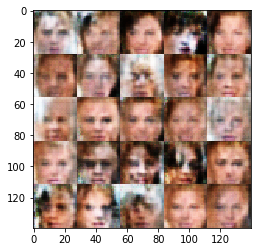


 Epoch 1/1 Step 2700 Discriminator Loss: 2.1466 ...  Generator Loss: 0.2967

 Epoch 1/1 Step 2710 Discriminator Loss: 2.1660 ...  Generator Loss: 0.2723

 Epoch 1/1 Step 2720 Discriminator Loss: 2.4820 ...  Generator Loss: 0.2379

 Epoch 1/1 Step 2730 Discriminator Loss: 2.0605 ...  Generator Loss: 0.3086

 Epoch 1/1 Step 2740 Discriminator Loss: 2.4498 ...  Generator Loss: 0.2607

 Epoch 1/1 Step 2750 Discriminator Loss: 2.3666 ...  Generator Loss: 0.1980

 Epoch 1/1 Step 2760 Discriminator Loss: 1.9870 ...  Generator Loss: 0.3636

 Epoch 1/1 Step 2770 Discriminator Loss: 2.2255 ...  Generator Loss: 0.2456

 Epoch 1/1 Step 2780 Discriminator Loss: 2.1014 ...  Generator Loss: 0.2703

 Epoch 1/1 Step 2790 Discriminator Loss: 2.0599 ...  Generator Loss: 0.3397


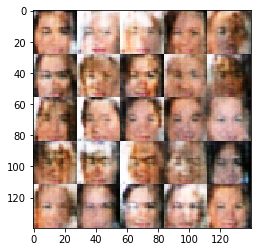


 Epoch 1/1 Step 2800 Discriminator Loss: 2.0843 ...  Generator Loss: 0.3228

 Epoch 1/1 Step 2810 Discriminator Loss: 2.0792 ...  Generator Loss: 0.3139

 Epoch 1/1 Step 2820 Discriminator Loss: 2.2206 ...  Generator Loss: 0.2415

 Epoch 1/1 Step 2830 Discriminator Loss: 2.0877 ...  Generator Loss: 0.3405

 Epoch 1/1 Step 2840 Discriminator Loss: 2.0744 ...  Generator Loss: 0.2994

 Epoch 1/1 Step 2850 Discriminator Loss: 2.2663 ...  Generator Loss: 0.2913

 Epoch 1/1 Step 2860 Discriminator Loss: 2.6283 ...  Generator Loss: 0.2256

 Epoch 1/1 Step 2870 Discriminator Loss: 2.6400 ...  Generator Loss: 0.1887

 Epoch 1/1 Step 2880 Discriminator Loss: 2.7121 ...  Generator Loss: 0.1904

 Epoch 1/1 Step 2890 Discriminator Loss: 2.0303 ...  Generator Loss: 0.2687


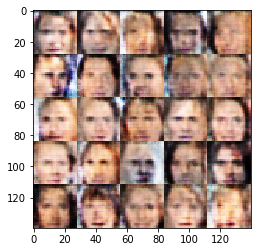


 Epoch 1/1 Step 2900 Discriminator Loss: 2.2655 ...  Generator Loss: 0.3116

 Epoch 1/1 Step 2910 Discriminator Loss: 2.1687 ...  Generator Loss: 0.2942

 Epoch 1/1 Step 2920 Discriminator Loss: 2.0805 ...  Generator Loss: 0.3782

 Epoch 1/1 Step 2930 Discriminator Loss: 2.1956 ...  Generator Loss: 0.3582

 Epoch 1/1 Step 2940 Discriminator Loss: 1.9858 ...  Generator Loss: 0.3858

 Epoch 1/1 Step 2950 Discriminator Loss: 2.3815 ...  Generator Loss: 0.2226

 Epoch 1/1 Step 2960 Discriminator Loss: 2.1512 ...  Generator Loss: 0.3211

 Epoch 1/1 Step 2970 Discriminator Loss: 2.1438 ...  Generator Loss: 0.3594

 Epoch 1/1 Step 2980 Discriminator Loss: 2.0018 ...  Generator Loss: 0.3828

 Epoch 1/1 Step 2990 Discriminator Loss: 2.2372 ...  Generator Loss: 0.2888


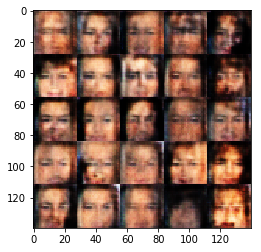


 Epoch 1/1 Step 3000 Discriminator Loss: 1.8364 ...  Generator Loss: 0.3841

 Epoch 1/1 Step 3010 Discriminator Loss: 2.1314 ...  Generator Loss: 0.3349

 Epoch 1/1 Step 3020 Discriminator Loss: 1.8177 ...  Generator Loss: 0.4026

 Epoch 1/1 Step 3030 Discriminator Loss: 2.1525 ...  Generator Loss: 0.2784

 Epoch 1/1 Step 3040 Discriminator Loss: 2.0604 ...  Generator Loss: 0.3588

 Epoch 1/1 Step 3050 Discriminator Loss: 2.0032 ...  Generator Loss: 0.3317

 Epoch 1/1 Step 3060 Discriminator Loss: 1.9853 ...  Generator Loss: 0.3310

 Epoch 1/1 Step 3070 Discriminator Loss: 2.1811 ...  Generator Loss: 0.2894

 Epoch 1/1 Step 3080 Discriminator Loss: 2.0902 ...  Generator Loss: 0.3066

 Epoch 1/1 Step 3090 Discriminator Loss: 1.8059 ...  Generator Loss: 0.4099


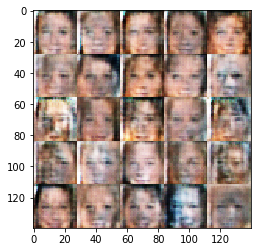


 Epoch 1/1 Step 3100 Discriminator Loss: 2.1201 ...  Generator Loss: 0.3694

 Epoch 1/1 Step 3110 Discriminator Loss: 2.1718 ...  Generator Loss: 0.2744

 Epoch 1/1 Step 3120 Discriminator Loss: 2.3813 ...  Generator Loss: 0.2669

 Epoch 1/1 Step 3130 Discriminator Loss: 2.0744 ...  Generator Loss: 0.3576

 Epoch 1/1 Step 3140 Discriminator Loss: 1.9212 ...  Generator Loss: 0.4573

 Epoch 1/1 Step 3150 Discriminator Loss: 1.9693 ...  Generator Loss: 0.3739

 Epoch 1/1 Step 3160 Discriminator Loss: 2.1998 ...  Generator Loss: 0.3283

 Epoch 1/1 Step 3170 Discriminator Loss: 2.1996 ...  Generator Loss: 0.2766

 Epoch 1/1 Step 3180 Discriminator Loss: 2.1323 ...  Generator Loss: 0.2770

 Epoch 1/1 Step 3190 Discriminator Loss: 2.7032 ...  Generator Loss: 0.2213


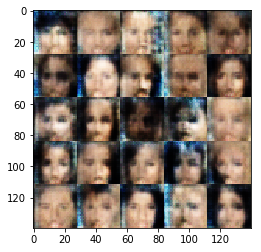


 Epoch 1/1 Step 3200 Discriminator Loss: 2.1441 ...  Generator Loss: 0.3403

 Epoch 1/1 Step 3210 Discriminator Loss: 1.8601 ...  Generator Loss: 0.3494

 Epoch 1/1 Step 3220 Discriminator Loss: 1.9588 ...  Generator Loss: 0.4205

 Epoch 1/1 Step 3230 Discriminator Loss: 2.2060 ...  Generator Loss: 0.2978

 Epoch 1/1 Step 3240 Discriminator Loss: 1.9791 ...  Generator Loss: 0.3560

 Epoch 1/1 Step 3250 Discriminator Loss: 2.0382 ...  Generator Loss: 0.3559

 Epoch 1/1 Step 3260 Discriminator Loss: 2.2720 ...  Generator Loss: 0.2663

 Epoch 1/1 Step 3270 Discriminator Loss: 1.9966 ...  Generator Loss: 0.3725

 Epoch 1/1 Step 3280 Discriminator Loss: 2.3418 ...  Generator Loss: 0.2683

 Epoch 1/1 Step 3290 Discriminator Loss: 2.0270 ...  Generator Loss: 0.2933


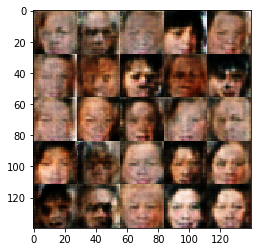


 Epoch 1/1 Step 3300 Discriminator Loss: 1.9866 ...  Generator Loss: 0.3557

 Epoch 1/1 Step 3310 Discriminator Loss: 2.1501 ...  Generator Loss: 0.2920

 Epoch 1/1 Step 3320 Discriminator Loss: 2.1551 ...  Generator Loss: 0.2793

 Epoch 1/1 Step 3330 Discriminator Loss: 2.1969 ...  Generator Loss: 0.2790

 Epoch 1/1 Step 3340 Discriminator Loss: 2.0930 ...  Generator Loss: 0.3119

 Epoch 1/1 Step 3350 Discriminator Loss: 2.3141 ...  Generator Loss: 0.2453

 Epoch 1/1 Step 3360 Discriminator Loss: 1.8374 ...  Generator Loss: 0.4409

 Epoch 1/1 Step 3370 Discriminator Loss: 2.2461 ...  Generator Loss: 0.3024

 Epoch 1/1 Step 3380 Discriminator Loss: 2.4843 ...  Generator Loss: 0.1974

 Epoch 1/1 Step 3390 Discriminator Loss: 2.0104 ...  Generator Loss: 0.3808


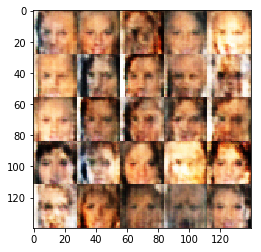


 Epoch 1/1 Step 3400 Discriminator Loss: 2.1714 ...  Generator Loss: 0.3732

 Epoch 1/1 Step 3410 Discriminator Loss: 1.9111 ...  Generator Loss: 0.3772

 Epoch 1/1 Step 3420 Discriminator Loss: 2.0914 ...  Generator Loss: 0.3479

 Epoch 1/1 Step 3430 Discriminator Loss: 2.2593 ...  Generator Loss: 0.2453

 Epoch 1/1 Step 3440 Discriminator Loss: 2.3173 ...  Generator Loss: 0.2449

 Epoch 1/1 Step 3450 Discriminator Loss: 2.4022 ...  Generator Loss: 0.2498

 Epoch 1/1 Step 3460 Discriminator Loss: 1.9424 ...  Generator Loss: 0.3213

 Epoch 1/1 Step 3470 Discriminator Loss: 2.3104 ...  Generator Loss: 0.2895

 Epoch 1/1 Step 3480 Discriminator Loss: 2.1760 ...  Generator Loss: 0.3071

 Epoch 1/1 Step 3490 Discriminator Loss: 2.2819 ...  Generator Loss: 0.2627


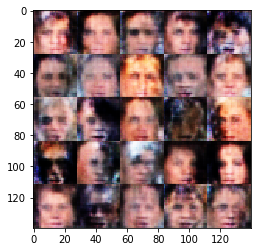


 Epoch 1/1 Step 3500 Discriminator Loss: 2.1092 ...  Generator Loss: 0.3510

 Epoch 1/1 Step 3510 Discriminator Loss: 2.0992 ...  Generator Loss: 0.3351

 Epoch 1/1 Step 3520 Discriminator Loss: 2.1478 ...  Generator Loss: 0.3035

 Epoch 1/1 Step 3530 Discriminator Loss: 1.7443 ...  Generator Loss: 0.4521

 Epoch 1/1 Step 3540 Discriminator Loss: 1.8292 ...  Generator Loss: 0.4181

 Epoch 1/1 Step 3550 Discriminator Loss: 2.0986 ...  Generator Loss: 0.3517

 Epoch 1/1 Step 3560 Discriminator Loss: 1.8919 ...  Generator Loss: 0.3714

 Epoch 1/1 Step 3570 Discriminator Loss: 2.1875 ...  Generator Loss: 0.2544

 Epoch 1/1 Step 3580 Discriminator Loss: 1.9882 ...  Generator Loss: 0.4993

 Epoch 1/1 Step 3590 Discriminator Loss: 1.9327 ...  Generator Loss: 0.3762


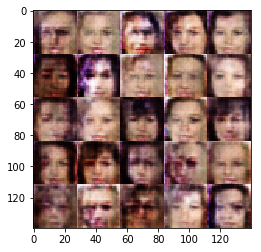


 Epoch 1/1 Step 3600 Discriminator Loss: 1.8160 ...  Generator Loss: 0.4392

 Epoch 1/1 Step 3610 Discriminator Loss: 1.8514 ...  Generator Loss: 0.3814

 Epoch 1/1 Step 3620 Discriminator Loss: 1.9612 ...  Generator Loss: 0.4550

 Epoch 1/1 Step 3630 Discriminator Loss: 2.1973 ...  Generator Loss: 0.2979

 Epoch 1/1 Step 3640 Discriminator Loss: 2.0538 ...  Generator Loss: 0.2951

 Epoch 1/1 Step 3650 Discriminator Loss: 1.9950 ...  Generator Loss: 0.3565

 Epoch 1/1 Step 3660 Discriminator Loss: 2.2481 ...  Generator Loss: 0.2731

 Epoch 1/1 Step 3670 Discriminator Loss: 2.3556 ...  Generator Loss: 0.2947

 Epoch 1/1 Step 3680 Discriminator Loss: 2.4019 ...  Generator Loss: 0.2530

 Epoch 1/1 Step 3690 Discriminator Loss: 1.8695 ...  Generator Loss: 0.3735


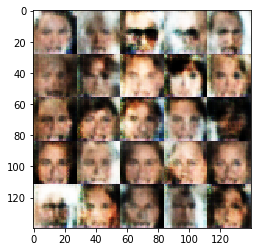


 Epoch 1/1 Step 3700 Discriminator Loss: 2.1224 ...  Generator Loss: 0.3421

 Epoch 1/1 Step 3710 Discriminator Loss: 2.3204 ...  Generator Loss: 0.2726

 Epoch 1/1 Step 3720 Discriminator Loss: 2.1450 ...  Generator Loss: 0.3468

 Epoch 1/1 Step 3730 Discriminator Loss: 2.0557 ...  Generator Loss: 0.3102

 Epoch 1/1 Step 3740 Discriminator Loss: 1.8398 ...  Generator Loss: 0.4108

 Epoch 1/1 Step 3750 Discriminator Loss: 1.9160 ...  Generator Loss: 0.3762

 Epoch 1/1 Step 3760 Discriminator Loss: 1.9775 ...  Generator Loss: 0.3484

 Epoch 1/1 Step 3770 Discriminator Loss: 2.0609 ...  Generator Loss: 0.3165

 Epoch 1/1 Step 3780 Discriminator Loss: 2.1842 ...  Generator Loss: 0.3005

 Epoch 1/1 Step 3790 Discriminator Loss: 2.0201 ...  Generator Loss: 0.3313


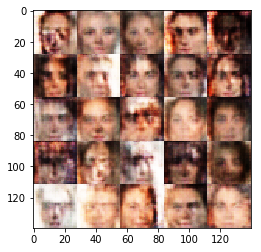


 Epoch 1/1 Step 3800 Discriminator Loss: 2.3412 ...  Generator Loss: 0.2550

 Epoch 1/1 Step 3810 Discriminator Loss: 1.9620 ...  Generator Loss: 0.3427

 Epoch 1/1 Step 3820 Discriminator Loss: 2.2317 ...  Generator Loss: 0.2735

 Epoch 1/1 Step 3830 Discriminator Loss: 2.4478 ...  Generator Loss: 0.2268

 Epoch 1/1 Step 3840 Discriminator Loss: 2.1450 ...  Generator Loss: 0.3043

 Epoch 1/1 Step 3850 Discriminator Loss: 2.1519 ...  Generator Loss: 0.3294

 Epoch 1/1 Step 3860 Discriminator Loss: 1.9595 ...  Generator Loss: 0.3450

 Epoch 1/1 Step 3870 Discriminator Loss: 2.3320 ...  Generator Loss: 0.2203

 Epoch 1/1 Step 3880 Discriminator Loss: 2.4050 ...  Generator Loss: 0.2372

 Epoch 1/1 Step 3890 Discriminator Loss: 2.1316 ...  Generator Loss: 0.3244


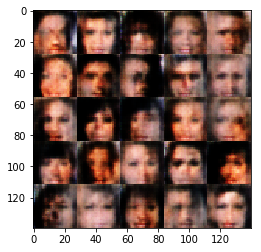


 Epoch 1/1 Step 3900 Discriminator Loss: 2.0295 ...  Generator Loss: 0.2799

 Epoch 1/1 Step 3910 Discriminator Loss: 1.9900 ...  Generator Loss: 0.4428

 Epoch 1/1 Step 3920 Discriminator Loss: 1.8677 ...  Generator Loss: 0.3527

 Epoch 1/1 Step 3930 Discriminator Loss: 1.8677 ...  Generator Loss: 0.3795

 Epoch 1/1 Step 3940 Discriminator Loss: 1.9189 ...  Generator Loss: 0.3657

 Epoch 1/1 Step 3950 Discriminator Loss: 1.9744 ...  Generator Loss: 0.3360

 Epoch 1/1 Step 3960 Discriminator Loss: 2.1400 ...  Generator Loss: 0.3236

 Epoch 1/1 Step 3970 Discriminator Loss: 2.1240 ...  Generator Loss: 0.3346

 Epoch 1/1 Step 3980 Discriminator Loss: 1.9323 ...  Generator Loss: 0.4001

 Epoch 1/1 Step 3990 Discriminator Loss: 2.2303 ...  Generator Loss: 0.2299


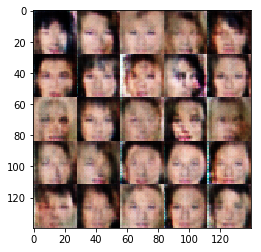


 Epoch 1/1 Step 4000 Discriminator Loss: 1.8215 ...  Generator Loss: 0.4697

 Epoch 1/1 Step 4010 Discriminator Loss: 2.0444 ...  Generator Loss: 0.3762

 Epoch 1/1 Step 4020 Discriminator Loss: 1.8097 ...  Generator Loss: 0.4118

 Epoch 1/1 Step 4030 Discriminator Loss: 2.0201 ...  Generator Loss: 0.3402

 Epoch 1/1 Step 4040 Discriminator Loss: 1.9277 ...  Generator Loss: 0.3623

 Epoch 1/1 Step 4050 Discriminator Loss: 2.0434 ...  Generator Loss: 0.3773

 Epoch 1/1 Step 4060 Discriminator Loss: 2.0261 ...  Generator Loss: 0.2947

 Epoch 1/1 Step 4070 Discriminator Loss: 1.8201 ...  Generator Loss: 0.4422

 Epoch 1/1 Step 4080 Discriminator Loss: 2.2511 ...  Generator Loss: 0.2516

 Epoch 1/1 Step 4090 Discriminator Loss: 2.0147 ...  Generator Loss: 0.4053


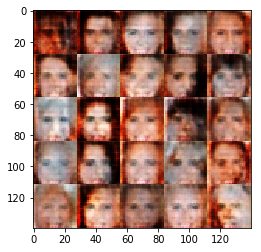


 Epoch 1/1 Step 4100 Discriminator Loss: 2.0937 ...  Generator Loss: 0.2968

 Epoch 1/1 Step 4110 Discriminator Loss: 1.9442 ...  Generator Loss: 0.3925

 Epoch 1/1 Step 4120 Discriminator Loss: 1.9726 ...  Generator Loss: 0.4157

 Epoch 1/1 Step 4130 Discriminator Loss: 1.7129 ...  Generator Loss: 0.4643

 Epoch 1/1 Step 4140 Discriminator Loss: 2.0088 ...  Generator Loss: 0.3759

 Epoch 1/1 Step 4150 Discriminator Loss: 1.8633 ...  Generator Loss: 0.3894

 Epoch 1/1 Step 4160 Discriminator Loss: 2.1132 ...  Generator Loss: 0.2986

 Epoch 1/1 Step 4170 Discriminator Loss: 2.3407 ...  Generator Loss: 0.2797

 Epoch 1/1 Step 4180 Discriminator Loss: 2.4013 ...  Generator Loss: 0.2466

 Epoch 1/1 Step 4190 Discriminator Loss: 2.3660 ...  Generator Loss: 0.2357


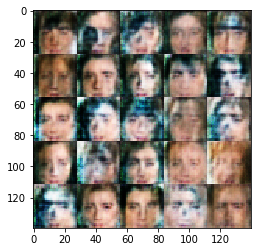


 Epoch 1/1 Step 4200 Discriminator Loss: 2.3061 ...  Generator Loss: 0.2309

 Epoch 1/1 Step 4210 Discriminator Loss: 2.2575 ...  Generator Loss: 0.2627

 Epoch 1/1 Step 4220 Discriminator Loss: 1.8833 ...  Generator Loss: 0.4162

 Epoch 1/1 Step 4230 Discriminator Loss: 2.1088 ...  Generator Loss: 0.3047

 Epoch 1/1 Step 4240 Discriminator Loss: 2.2177 ...  Generator Loss: 0.3180

 Epoch 1/1 Step 4250 Discriminator Loss: 1.7300 ...  Generator Loss: 0.4188

 Epoch 1/1 Step 4260 Discriminator Loss: 1.9047 ...  Generator Loss: 0.3719

 Epoch 1/1 Step 4270 Discriminator Loss: 2.4514 ...  Generator Loss: 0.2224

 Epoch 1/1 Step 4280 Discriminator Loss: 1.9962 ...  Generator Loss: 0.3481

 Epoch 1/1 Step 4290 Discriminator Loss: 2.0659 ...  Generator Loss: 0.3292


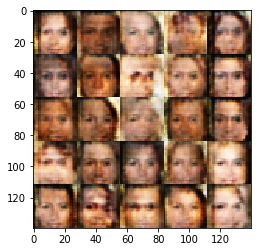


 Epoch 1/1 Step 4300 Discriminator Loss: 1.8445 ...  Generator Loss: 0.4119

 Epoch 1/1 Step 4310 Discriminator Loss: 2.1583 ...  Generator Loss: 0.3569

 Epoch 1/1 Step 4320 Discriminator Loss: 1.9457 ...  Generator Loss: 0.3280


KeyboardInterrupt: 

In [35]:
batch_size = 16
z_dim = 128
learning_rate = .0002
beta1 = .3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.